### Machine learning for Systems & Control 5SC28 2021-2022

# Exercise Set Lecture 4: ANN with Python

This tutorial will go over the basics of deep learning in Python using PyTorch.

1. <a href="#Exercise-1:-Manual-Implementation-Neural-Network">Exercise 1: Manual Implementation Neural Network</a>
2. <a href="#Exercise-2:-Autograd/Backprop">Exercise 2: Autograd/Backprop</a>
3. <a href="#(Demo)-Exercise-3:-a-simple-Neural-Network-in-Pytorch">(Demo) Exercise 3: a simple Neural Network in Pytorch</a>
4. <a href="#Exercise-4:-Implement-your-Neural-Network">Exercise 4: Implement your Neural Network</a>
5. <a href="#(Optional)-Exercise-5:-Approximation-Properties">(Optional) Exercise 5: Approximation Properties</a>
6. <a href="#Exercise-6:-ANN-for-NARX">Exercise 6: ANN for NARX</a>

## Exercise 1: Manual Implementation Neural Network

### Data generation

**a)** Write a code cell that implements the normal equation given by 

$$  y = f(u) = \frac{1}{\sigma \sqrt{2\pi} } \exp \left ({-\frac{1}{2}\left(\frac{u-\mu_u}{\sigma_u}\right)^2} \right )$$

with  `sigma_u = 1.0` and `mu_u=0`. *tip: use `np.pi`, `np.exp` and `np.sqrt`*

**b)** Apply this function to obtain `y_data` generated by the inputs `u_data` which are sampled from a uniform distribution between `-4*sigma_u` and `4*sigma_u` using 200 samples. 

*tip: use `np.random.uniform` and its associated documentation*.

**c)** plot the input on the x-axis and the output on the y axis using `plt.plot`

*tip: add `'.'` to the argument to make it a scatter plot*

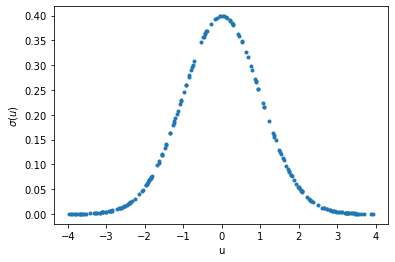

In [1]:
import numpy as np # array operations
from matplotlib import pyplot as plt # plotting

def Normal(u, sigma_u, mu_u): 
    y = 1/(sigma_u*np.sqrt(2*np.pi))*np.exp(-1/2*((u-mu_u)/sigma_u)**2) #a=)
    return y

sigma_u = 1
mu_u = 0
u_data = np.random.uniform(-4*sigma_u,4*sigma_u,size=200) #b)
y_data = Normal(u_data,sigma_u,mu_u) #b)
plt.plot(u_data,y_data,'.') #c)
plt.xlabel('u'); plt.ylabel(r'$\sigma(u)$') #c)
plt.show() #c)


### Neural network Implementation

Implement a neural network with the given set of parameters (see w1-w3, b1-b3 below). 

**a)** Implement the sigmoid function given by:

$$
 \sigma(x) = \frac{1}{1+\exp(-x)}
$$

**b)** write the network which has: 
  * 2 hidden layers 
  * 3 nodes in each hidden layer
  * Sigmoid activations (excluding the last layer)

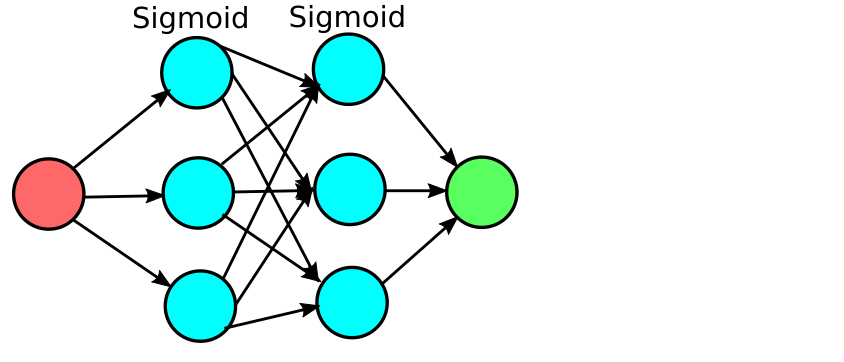

*tip: use `np.dot(w2,x1)` or `@` for matrix vector product*

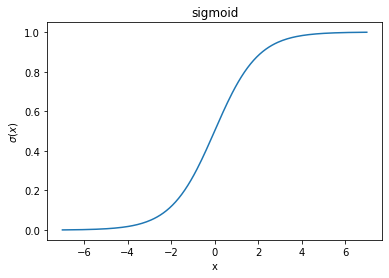

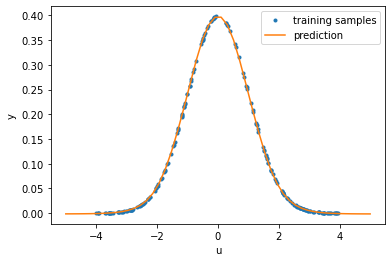

In [2]:
#this code bock re-uses u_data,y_data
import numpy as np
from matplotlib import pyplot as plt
def sigmoid(x):
    return 1/(1+np.exp(-x)) #a)

plt.title('sigmoid')
x = np.linspace(-7,7,num=200)
plt.plot(x,sigmoid(x))
plt.xlabel('x')
plt.ylabel(r'$\sigma(x)$')
plt.show()

u_data = np.random.uniform(-4,4,size=200) #generate the same data as Exercise 1.
y_data = np.exp(-u_data**2/2)/(np.sqrt(2*np.pi))

#already fitted neural network parameters:
w1 = np.array([-3.20651507, -2.22372897, -2.24205213])
b1 = np.array([ 1.7777133 ,  3.01726445, -2.80330611])
w2 = np.array([[ 0.96298131,  0.97024341, -6.48872239],
               [-0.86327357, -1.96268265,  2.43754417],
               [ 1.17725663,  1.62308542, -2.42189463]])
b2 = np.array([-1.77587714,  0.8344014 , -0.97899131])
w3 = np.array([[ 0.34505691, -0.34256864,  0.23994211]])
b3 = np.array([0.12171841])
def network(u):
    #u == scalar here
    x1 = sigmoid(w1*u+b1) #b)
    x2 = sigmoid(np.dot(w2,x1)+b2) #b)
    y = np.dot(w3,x2)+b3 #b=)
    return y

plt.plot(u_data,y_data,'.')
u_test = np.linspace(-5,5)
y_data_prediced = [network(ui) for ui in u_test] #apply one by one
plt.plot(u_test,y_data_prediced)
plt.legend(['training samples','prediction'])
plt.xlabel('u'); plt.ylabel('y')
plt.show()

### Exercise 2: Autograd/Backprop

One of the main backbones of deep learning is automatic differentiation by backpropagation. All deep learning toolboxes (i.e. modules) include such an engine. 

Currently, the most popular deep learning framework is [PyTorch](https://pytorch.org/). It performs best at deep learning problems of medium size. 

*note: small problems (cpu only) = sklearn, medium = Pytorch, large (requiring extensive distributed optimization) = Caffle, Tensorflow, and many others, exodic computations = jax)*

Pytorch is imported using the name `torch` which has automatic differentiation capabilities. **See the example below.**

$$ y = 2 x^2 + x + 1$$

$$ \left . \frac{dy}{dx} \right |_{x=1} = \left . (4 x + 1) \right |_{x=1} =5$$

Here `y.backward()` will propagate the gradient backwards to all `Variables` and put the gradient in the `.grad` attribute. Note that `x.data` holds the data of x.

In [3]:
import torch #import the deep learning framework torch which has automatic differentiation

x = torch.tensor(1.,requires_grad=True) # an input variable of the function with the value of 1.

y = 2*x**2+x+1 #any function you want which uses torch methods, such as torch.sin, torch.exp, torch.sigmoid
y.backward() #This will propagate the gradient backwards to .grad attribute of all requires_grad variables: x.grad = dy/dx
print('after 1 backward: y=',y.data,', dy/dx=',x.grad,', dy/dx by hand',(4*x+1).data)

after 1 backward: y= tensor(4.) , dy/dx= tensor(5.) , dy/dx by hand tensor(5.)


**Important note:** *the gradient buffer is accumulative when calling `.backward` multiple times which might result in an error when not handled correctly [Documentation](https://pytorch.org/tutorials/recipes/recipes/zeroing_out_gradients.html). See example below* 

For this reason, one needs to call the `zero_` method to reset the gradient buffer to zero.

In [4]:
import torch #import the deep learning framework torch which has automatic differentiation

x = torch.tensor(1.,requires_grad=True)
                                                                 
y = 2*x**2+x+1 
y.backward(retain_graph=True) #retain_graph=True otherwise backwards can only be called ones (buffers are cleared)
print('after 1 backward: y=',y.data,', dy/dx=',x.grad,', dy/dx by hand',(4*x+1).data)

y.backward(retain_graph=True) #call backwards again which adds the gradient to the x.grad again which could be undesirable
print('after 2 backward: y=',y.data,', dy/dx=',x.grad,', dy/dx by hand',(4*x+1).data)

####### crucial bit ######
x.grad.data.zero_() #manually set the gradient data to zero which resets the buffer
##########################

y.backward(retain_graph=True) #This will propagate the gradient backwards 
print('after 3 with zero_ call backward: y=',y.data,', dy/dx=',x.grad,', dy/dx by hand',(4*x+1).data)

after 1 backward: y= tensor(4.) , dy/dx= tensor(5.) , dy/dx by hand tensor(5.)
after 2 backward: y= tensor(4.) , dy/dx= tensor(10.) , dy/dx by hand tensor(5.)
after 3 with zero_ call backward: y= tensor(4.) , dy/dx= tensor(5.) , dy/dx by hand tensor(5.)




**a)** Let's illustrate the power of the autograd module. Implement the [Newton root finding algorithm](https://en.wikipedia.org/wiki/Newton%27s_method) and calculate $\pi$ by finding the root of $$\sin(x)=0$$ starting at 
$x_0=2.5$.

*tip: the Newton method is given by*
$$ x_{i+1} = x_{i} + \delta x_{i}$$
$$ f(x_{i}+\delta x_{i}) \approx f(x_{i}) + f'(x_{i}) \delta x_{i} = 0$$
$$ \delta x_{i} = -\frac{f(x_i)}{f'(x_i)}$$
*tips: use `torch.sin` and the value of a tensor can be changed by modifying `.data` attribute (e.g. `x.data = 1`)*

In [5]:
import torch #import the deep learning framework torch which has automatic differentiation
x0 = 2.5
x = torch.tensor(x0,dtype=torch.float64,requires_grad=True)
print(f'iteration: {0}, pi={np.pi}, x={x.data.item()}, difference = {x.data.item() - np.pi}')
for i in range(1,10):

    y = torch.sin(x) #a)
    y.backward() #a)
    delta_x = y/x.grad #a)
    x.data -= delta_x #a) equivalent to x.data = x.data - delta_x
    
    x.grad.data.zero_() #this will set the gradient zero before next step
    print(f'iteration: {i}, pi={np.pi}, x={x.data.item()}, difference = {x.data.item() - np.pi}')
    

iteration: 0, pi=3.141592653589793, x=2.5, difference = -0.6415926535897931
iteration: 1, pi=3.141592653589793, x=3.24702229723866, difference = 0.10542964364886709
iteration: 2, pi=3.141592653589793, x=3.141200277699888, difference = -0.00039237588990514993
iteration: 3, pi=3.141592653589793, x=3.14159265360993, difference = 2.013678113144124e-11
iteration: 4, pi=3.141592653589793, x=3.141592653589793, difference = 0.0
iteration: 5, pi=3.141592653589793, x=3.141592653589793, difference = 0.0
iteration: 6, pi=3.141592653589793, x=3.141592653589793, difference = 0.0
iteration: 7, pi=3.141592653589793, x=3.141592653589793, difference = 0.0
iteration: 8, pi=3.141592653589793, x=3.141592653589793, difference = 0.0
iteration: 9, pi=3.141592653589793, x=3.141592653589793, difference = 0.0


**b)** Write a non-linear fitting optimizer using steepest decent. Do this for the following function: 

$$ f_0(x) = a_0 (1-exp(-x/b_0)) + c_0 + \varepsilon$$

$$ a_0 = 5, b_0 = 2.25, c_0 = -2, \varepsilon \sim N(0,0.1)$$

starting from $a=4$, $b=2$ and $c=1$. 

Remember that steepest decent is given by:

$$ a^{+} = a - \alpha \frac{dL}{da}$$

with $L$ the mean square loss: 

$$L = \frac{1}{N} \sum_{i=1}^N (y_i-\hat y_i)^2$$

*tip: use `torch.mean` to calculate a mean*

*tip: don’t forget to reset the gradients to zero*

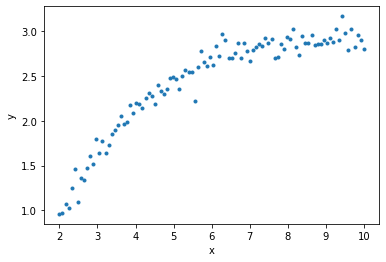

epoch=0, Loss=4.907081127166748
epoch=500, Loss=0.018048042431473732
epoch=1000, Loss=0.013972950167953968
epoch=1500, Loss=0.013121822848916054
epoch=2000, Loss=0.012654938735067844
epoch=2500, Loss=0.012265956029295921
epoch=3000, Loss=0.011921774595975876
epoch=3500, Loss=0.011616218835115433
epoch=4000, Loss=0.01134522631764412
epoch=4500, Loss=0.01110497210174799
epoch=5000, Loss=0.010891830548644066
epoch=5500, Loss=0.010702588595449924
epoch=6000, Loss=0.010534320957958698
epoch=6500, Loss=0.010384507477283478
epoch=7000, Loss=0.010250895284116268
epoch=7500, Loss=0.010131542570888996
epoch=8000, Loss=0.010024745017290115
epoch=8500, Loss=0.009929021820425987
epoch=9000, Loss=0.009843087755143642
epoch=9500, Loss=0.009765802882611752
epoch=10000, Loss=0.009696193039417267
epoch=10500, Loss=0.009633407928049564
epoch=11000, Loss=0.009576673619449139
epoch=11500, Loss=0.009525347501039505
epoch=12000, Loss=0.009478859603404999
epoch=12500, Loss=0.00943668931722641
epoch=13000, Los

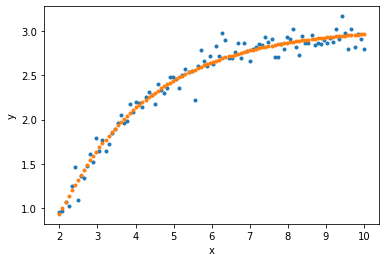

a0= 5 a fitted = 4.86256217956543
b0= 2.25 b fitted = 2.381540536880493
c0= -2 c fitted = -1.8256473541259766


In [6]:
import torch
#data generation
x_data = torch.linspace(2,10,steps=100)
a0, b0, c0 = 5, 2.25, -2
y_data = (a0*(1-torch.exp(-x_data/b0))+c0 + torch.randn(100)/10).detach()
plt.plot(x_data,y_data,'.')
plt.xlabel('x'); plt.ylabel('y')
plt.show()

#Variable creation, initially a=4, b=2, c=1
a = torch.tensor(4.,requires_grad=True)
b = torch.tensor(2.,requires_grad=True)
c = torch.tensor(1.,requires_grad=True)
alpha = 5e-2 #the learning rate

for epoch in range(20000):

    #cal Loss and gradient
    y_predict = a*(1-torch.exp(-x_data/b))+c #b)
    Loss = torch.mean((y_predict-y_data)**2) #b=)
    Loss.backward() #b)
    
    #apply gradient
    a.data -= alpha*a.grad.data #b)
    b.data -= alpha*b.grad.data #b)
    c.data -= alpha*c.grad.data #b)

    #zero grad
    a.grad.data.zero_() #b)
    b.grad.data.zero_() #b)
    c.grad.data.zero_() #b)
    
    if epoch%500==0: 
        print(f'epoch={epoch}, Loss={Loss.item()}') # enable this for a monitor while optimizing

    
with torch.no_grad(): #making a with torch.no_grad(): will make it so that gradients will not be calculated
                      #this makes plotting and result analysis much simpler
    plt.plot(x_data,y_data,'.')
    plt.plot(x_data,a*(1-torch.exp(-x_data/b))+c,'.')
    plt.xlabel('x'); plt.ylabel('y')
    plt.show()
    print('a0=',a0,'a fitted =',a.item())
    print('b0=',b0,'b fitted =',b.item())
    print('c0=',c0,'c fitted =',c.item())

Alternatively, one can use the optimizers that are already included in PyTorch. For instance, you can find the implementation for the previous problem using the `torch.optim.SGD` optimizer below. 

*note: using `torch.optim.SGD` when using the whole batch is equivalent to using Gradient Decent*

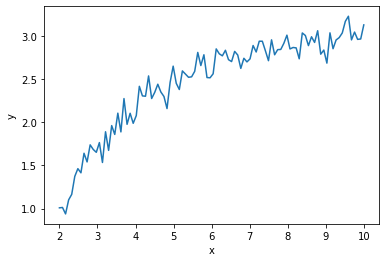

0 4.76951789855957
500 0.019701138138771057
1000 0.015967048704624176
1500 0.015297110192477703
2000 0.014984798617661
2500 0.01473288144916296
3000 0.014508620835840702
3500 0.014307260513305664
4000 0.014126583002507687
4500 0.01396456453949213
5000 0.0138193154707551
5500 0.013689045794308186
6000 0.013572167605161667
6500 0.013467198237776756
7000 0.013372867368161678
7500 0.013288007117807865
8000 0.01321157906204462
8500 0.01314267423003912
9000 0.013080477714538574
9500 0.013024283573031425
10000 0.012973451986908913
10500 0.012927420437335968
11000 0.012885685078799725
11500 0.01284781564027071
12000 0.01281341165304184
12500 0.012782127596437931
13000 0.012753657065331936
13500 0.012727702036499977
14000 0.01270404551178217
14500 0.012682459317147732
15000 0.012662729248404503
15500 0.012644708156585693
16000 0.012628219090402126
16500 0.012613113969564438
17000 0.012599281035363674
17500 0.012586597353219986
18000 0.012574954889714718
18500 0.012564275413751602
19000 0.012554

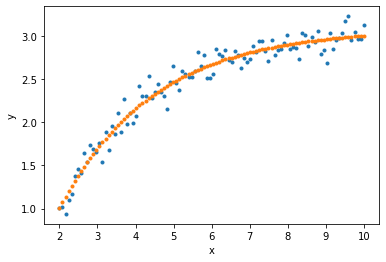

a0= 5 a fitted = 4.649409770965576
b0= 2.25 b fitted = 2.477386474609375
c0= -2 c fitted = -1.5675785541534424


In [7]:
import torch
a0,b0,c0 = 5, 2.25, -2

x_data = torch.linspace(2,10,steps=100)
y_data = (a0*(1-torch.exp(-x_data/b0))+c0 + torch.randn(100)/10).detach()
plt.plot(x_data,y_data)
plt.xlabel('x'); plt.ylabel('y')
plt.show()

a = torch.tensor(4.,requires_grad=True)
b = torch.tensor(2.,requires_grad=True)
c = torch.tensor(1.,requires_grad=True)
optimizer = torch.optim.SGD([a,b,c],lr=5e-2)

for epoch in range(20000):
    optimizer.zero_grad() #zero the gradients

    y_predict = a*(1-torch.exp(-x_data/b))+c
    Loss = torch.mean((y_predict-y_data)**2) #calculate loss
    Loss.backward() 
    optimizer.step() #step the optimizer to update the parameter using the gradients
    if epoch%500==0: 
        print(epoch,Loss.item())
    
with torch.no_grad():
    plt.plot(x_data,y_data,'.')
    plt.plot(x_data,a*(1-torch.exp(-x_data/b))+c,'.')
    plt.xlabel('x'); plt.ylabel('y')
    plt.show()
    print('a0=',a0,'a fitted =',a.item())
    print('b0=',b0,'b fitted =',b.item())
    print('c0=',c0,'c fitted =',c.item())

(optional) Read (some of) the `Introduction to PyTorch Tensors` on [pytorch.org](https://pytorch.org/tutorials/beginner/introyt/tensors_deeper_tutorial.html), with a nice [youtube video](https://www.youtube.com/watch?v=r7QDUPb2dCM).

Important part; [Converting to numpy arrays from and to tensors](https://pytorch.org/tutorials/beginner/introyt/tensors_deeper_tutorial.html#numpy-bridge)

### (Demo) Exercise 3: a simple Neural Network in Pytorch

Most often the gradients are used for the first-order optimization of neural networks. An example of such can be seen below.

#### Create/Load data:

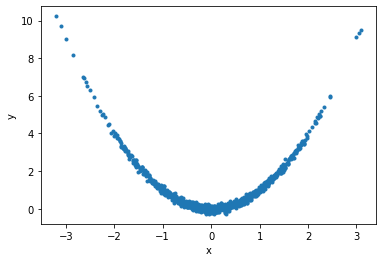

In [8]:
import torch

X_data = torch.randn((1000,),dtype=torch.float64) #draw 1000 samples from a normal distributions
Y_data = X_data**2 #function to predict is a simple quadratic
Y_data += torch.randn((1000,),dtype=torch.float64)/10 #a bit of noise
plt.plot(X_data.numpy(),Y_data.numpy(),'.')
plt.xlabel('x'); plt.ylabel('y')
plt.show()

#### Create network and optimizer:

In [9]:
import torch
from torch import nn

# create the structure of the neural network
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__() #don't worry much about what this does for now.
        self.lay1 = nn.Linear(1,15).double() # a linear fully connected layer from 1 features to 15 features
                                             # the activation function is defined in the forward (see below)
        self.lay2 = nn.Linear(15,1).double() # a linear fully connected layer from 15 features to 1 features
    
    def forward(self,u): # is called when model(anything) is called
        # u has input shape (N,)
        u = u[:,None] #convert u from shape (N,) to (N,1)
        x1 = torch.sigmoid(self.lay1(u)) #apply the input to the first layer and apply a sigmoid
        y = self.lay2(x1)[:,0] #pass through second layer which results in a shape (N,1) and convert it back to (N,)
        return y

model = Network() #create the network instance
print(model)
parameters = list(model.parameters()) #automatically generates a list of the model parameters
print(parameters) 
optimizer = torch.optim.SGD(parameters,lr=0.1)

Network(
  (lay1): Linear(in_features=1, out_features=15, bias=True)
  (lay2): Linear(in_features=15, out_features=1, bias=True)
)
[Parameter containing:
tensor([[-0.7544],
        [ 0.5145],
        [ 0.1584],
        [-0.7920],
        [-0.2226],
        [ 0.5092],
        [ 0.5636],
        [ 0.1582],
        [-0.1772],
        [-0.0230],
        [ 0.1472],
        [-0.8902],
        [ 0.2338],
        [-0.0948],
        [ 0.1742]], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([ 0.3110, -0.2003,  0.3710, -0.0450, -0.8848,  0.8941,  0.6674,  0.1614,
        -0.4481,  0.1647,  0.7411,  0.2719,  0.3384,  0.3992, -0.5670],
       dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([[ 0.0513,  0.1879, -0.0219, -0.1753,  0.0344,  0.1736, -0.1616, -0.0323,
         -0.0936, -0.1338,  0.1706, -0.0824,  0.0234,  0.0508, -0.0931]],
       dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([0.1909], dtype=torch.float64, requires_

#### Optimize

In [10]:
def CallLoss(X,Y):    
    return torch.mean((model(X)-Y)**2)

for epoch in range(20000):
    Loss = CallLoss(X_data,Y_data)
    optimizer.zero_grad() #set the gradient buffers to zero, this is essential.
    Loss.backward()
    optimizer.step()
    if epoch%500==0: print(f'epoch={epoch} Loss={Loss}')

epoch=0 Loss=2.620083528043276
epoch=500 Loss=0.20761761263469736
epoch=1000 Loss=0.06883509354989421
epoch=1500 Loss=0.04109929851542407
epoch=2000 Loss=0.03082624437637206
epoch=2500 Loss=0.02554155707996359
epoch=3000 Loss=0.022199634138357724
epoch=3500 Loss=0.01981481430931144
epoch=4000 Loss=0.017997271435928008
epoch=4500 Loss=0.01657513419793441
epoch=5000 Loss=0.015459133059399057
epoch=5500 Loss=0.01458522529588398
epoch=6000 Loss=0.013899131335718715
epoch=6500 Loss=0.013356808262949528
epoch=7000 Loss=0.012924754464055681
epoch=7500 Loss=0.012578000836520492
epoch=8000 Loss=0.012297762084738508
epoch=8500 Loss=0.012069676169788188
epoch=9000 Loss=0.011882630562872034
epoch=9500 Loss=0.011727973256461357
epoch=10000 Loss=0.011598953974658868
epoch=10500 Loss=0.011490306960613275
epoch=11000 Loss=0.011397927992649139
epoch=11500 Loss=0.011318619759150049
epoch=12000 Loss=0.011249890149270796
epoch=12500 Loss=0.011189792975761073
epoch=13000 Loss=0.011136803106872276
epoch=135

#### Plotting Results:

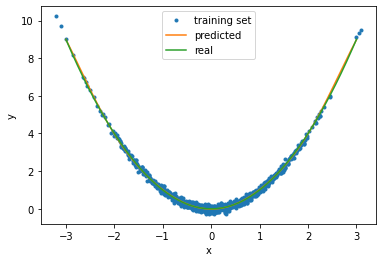

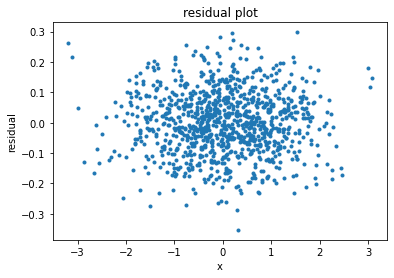

In [11]:
with torch.no_grad(): #such that gradients cannot be calculated and conversion to normal arrays is simpler.
    X_test = torch.linspace(-3,3,steps=1000,dtype=torch.float64)
    plt.plot(X_data,Y_data,'.',label='training set')
    plt.plot(X_test,model(X_test),label='predicted')
    plt.plot(X_test,X_test**2,label='real')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()
    
    plt.title('residual plot')
    plt.xlabel('x')
    plt.ylabel('residual')
    plt.plot(X_data,Y_data-model(X_data),'.')
    plt.show()
    

### Exercise 4: Implement your Neural Network

Now create your own Neural Network using PyTorch. 

 **a)** Create a network with 
  * 2 hidden layers 
  * 3 nodes (i.e neurons) per layer 
  * with sigmoid activation functions. (excluding the last layer)

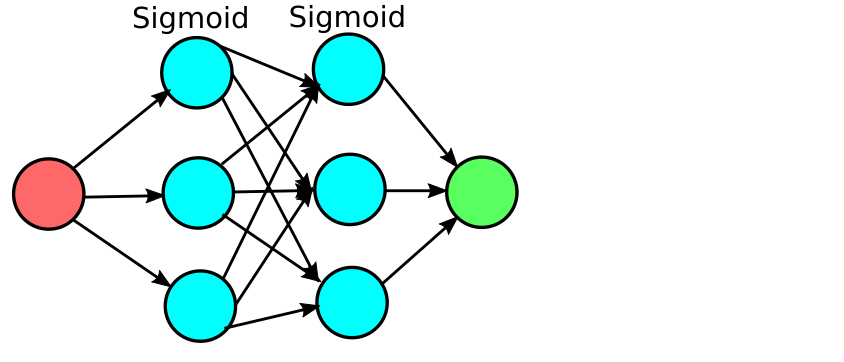

In [12]:
import torch
from torch import nn

class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        self.lay1 = nn.Linear(1,3).double() #a) new 1 to 3
        self.lay2 = nn.Linear(3,3).double() #a) new 3 to 3
        self.lay3 = nn.Linear(3,1).double() #a) new 3 to 1
    
    def forward(self,u):
        u = u[:,None]
        x1 = torch.sigmoid(self.lay1(u))  #a) new
        x2 = torch.sigmoid(self.lay2(x1)) #a) new
        y = self.lay3(x2)[:,0]            #a) new
        return y


**b)** Optimize the model by using the mean square error and SGD. Furthermore, try changing the learning rate `lr` to quicken the optimization process.

In [13]:
#data generation
u_data = np.random.uniform(-4,4,size=200)
y_data = np.exp(-u_data**2/2)/(np.sqrt(2*np.pi))

# convert numpy arrays to tensors such that it can be used by PyTorch
u_data, y_data = torch.tensor(u_data), torch.tensor(y_data) 


model = Network() #b)
optimizer = torch.optim.SGD(model.parameters(),lr=5e-1) #b)
for epoch in range(20000): #b)
    Loss = torch.mean((model(u_data)-y_data)**2) #b)
    optimizer.zero_grad() #b)
    Loss.backward() #b)
    optimizer.step() #b)
    if epoch%300==0: #b)
        print(epoch,Loss.item()/torch.std(y_data).item()) #b)

0 0.2789467069974617
300 0.12810932580986645
600 0.12492811458290648
900 0.11260745657052232
1200 0.06159883552262192
1500 0.008750110852107754
1800 0.004989439909284896
2100 0.002054825421013337
2400 0.0011070386138339087
2700 0.0006995234652846212
3000 0.0005103359883141532
3300 0.00041470687968625503
3600 0.00036100764661064057
3900 0.0003269443535083561
4200 0.0003025789427833277
4500 0.0002833611622637474
4800 0.00026714946797247685
5100 0.00025289978186935047
5400 0.00024007640313046148
5700 0.00022838344608248323
6000 0.00021764101237453458
6300 0.0002077274957182744
6600 0.00019855235733445196
6900 0.00019004303389970776
7200 0.0001821384446516454
7500 0.00017478560879294547
7800 0.00016793775147654072
8100 0.00016155314120926004
8400 0.000155594302602197
8700 0.0001500274348095585
9000 0.00014482195288941657
9300 0.0001399501100596859
9600 0.00013538667814824864
9900 0.00013110867290701047
10200 0.00012709511558027994
10500 0.00012332682464280453
10800 0.00011978623308889444
1

**c)** Plot the results overlaying the data and a residual plot.

*tip: use torch.no_grad()*

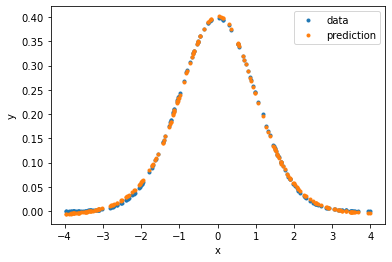

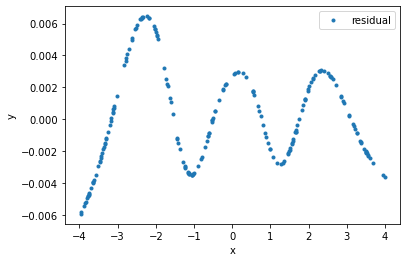

In [14]:
with torch.no_grad(): #c)
    plt.plot(u_data,y_data,'.') #c)
    plt.plot(u_data,model(u_data),'.') #c)
    plt.xlabel('x'); plt.ylabel('y') #c)
    plt.legend(['data','prediction']) #c)
    plt.show() #c)

    
    plt.plot(u_data,model(u_data)-y_data,'.') #c)
    plt.xlabel('x'); plt.ylabel('y') #c)
    plt.legend(['residual']) #c)
    plt.show() #c)

Now you know the basics of implementing a Neural Network in pytorch.

### (Optional) Exercise 5: Approximation Properties

As seen in the lectures the approximation properties of neural networks scale well with the dimentionallity of the problem. i.e. the loss scales with

$$
 V_{\text{ANN}} = O \left (\frac{1}{n} \right )\\
$$

where $n$ denotes the number of hidden neurons. Whereas basis function expansion (e.g. multivariate polynomials) with $n$ terms scales with
$$
 V_{\text{poly}} = O \left (\frac{1}{n^{2/n_u}} \right )
$$
where $n_u$ denotes the number of input variables. This exercise will illustrate this difference as an example.


Let us consider an example where we try to fit 

$$
y(u) = \sum_i \text{bool} (|u_i|<0.5)
$$
Where

$$
\text{bool}(\text{True}) = 1\\
\text{bool}(\text{False}) = 0
$$


where $u$ has 8 dimentions and is sampled from $U(-1.0, 1.0)$.

**a)** Run the data generation and polynomial fit cells and observe the results.

#### Data generation

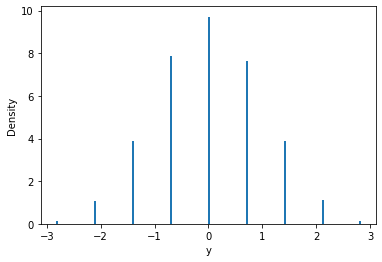

In [15]:
import numpy as np
import torch
from matplotlib import pyplot as plt

def get_data(Ndata):
    nu = 8 # number of inputs, can be modified
    gen_x = lambda: np.random.uniform(-1,1,size=(Ndata,nu))
    #Some other functions:
    #f = lambda x: np.sin(x[:,0]*x[:,1] + .5*x[:,2] + .5*x[:,1])*np.exp(-x[:,3]**2)
    #f = lambda x: 3*np.sin(-np.sum(x**2,axis=1)+0.5)
    
    #the main function:
    f = lambda x: np.sum(np.abs(x)<0.5,axis=1)
    Xtrain, Xtest = gen_x(), gen_x()
    Ytrain, Ytest = f(Xtrain), f(Xtest)
    m = np.mean([Ytrain,Ytest])
    s = np.std([Ytrain,Ytest])
    Ytrain = (Ytrain-m)/s # normalization for convenience 
    Ytest = (Ytest-m)/s
    return Xtrain, Ytrain, Xtest, Ytest

Xtrain, Ytrain, Xtest, Ytest = get_data(Ndata=2*10**4)
plt.hist(Ytrain,bins=200,density=True)
plt.ylabel('Density')
plt.xlabel('y')
plt.show()



#### Polynomial fitting

Run cell below, no modification required.

1
1.0000636825450424 9
2
0.5476187611504574 45
3
0.5493862073171648 165
4
0.4193121096649822 495
5
0.42818058498617817 1287
6
0.4480212522933544 3003


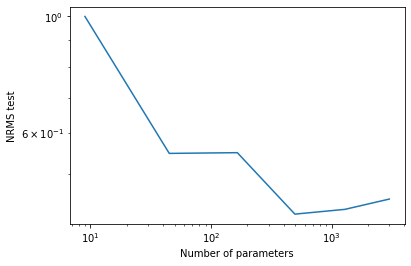

In [16]:
def get_pol(Xtrain, Ytrain, Xtest, Ytest, degree):
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.linear_model import LinearRegression
    from sklearn.pipeline import Pipeline
    
    model = Pipeline([('poly', PolynomialFeatures(degree=degree)),
                     ('linear', LinearRegression())])
    model.fit(Xtrain,Ytrain)
    Ytest_p = model.predict(Xtest)
    NRMStest = np.mean((Ytest-Ytest_p)**2)**0.5/np.std(Ytest)
    
    return NRMStest, len(model['linear'].coef_.flat), model

Npar_pol = []
NRMS_pol = []
Npar_old = 1
for degree in range(1,100): 
    print(degree)
    NRMStest, Nparameters, model = get_pol(Xtrain, Ytrain, Xtest, Ytest, degree)
    print(NRMStest, Nparameters)
    Npar_pol.append(Nparameters)
    NRMS_pol.append(NRMStest)
    if Nparameters**2/Npar_old>5e3: #stop when number of next parameter will be over 3*10^3
        break
    Npar_old = Nparameters
    
plt.loglog(Npar_pol,NRMS_pol)
plt.xlabel('Number of parameters')
plt.ylabel('NRMS test')
plt.show()

#### Construct ANN

**b)** Construct a sigmoid ANN with 1 hidden layer where the number of hidden nodes is a parameter of `__init__` (called when `Network(...)` is used) and finish the `get_ANN` function which fits the model for a given a number of epochs.

*tip: convert the `Xtrain,Ytrain, Xtest, Ytest` NumPy arrays to torch arrays using `as_tensor`*

In [17]:
from torch import nn
import torch
class Network(nn.Module): 
    def __init__(self, n_in, n_hidden_nodes): 
        super(Network,self).__init__() 
        self.lay1 = nn.Linear(n_in,n_hidden_nodes).double()  #b)
        self.lay2 = nn.Linear(n_hidden_nodes,1).double()  #b)
    
    def forward(self,u): 
        # u.shape == (N,10)
        x1 = torch.sigmoid(self.lay1(u))  #b)
        y = self.lay2(x1)[:,0] #b)
        return y #b)

def get_ANN(Xtrain,Ytrain, Xtest, Ytest, n_hidden_nodes, epochs=10000):
    model = Network(Xtrain.shape[1],n_hidden_nodes) #create the network
    
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-3) #b=)
    Xtrain,Ytrain, Xtest, Ytest = [torch.as_tensor(x) for x in [Xtrain,Ytrain, Xtest, Ytest]] #b)
    for epoch in range(epochs): 
        Loss = torch.mean((model(Xtrain)-Ytrain)**2) #b=)
        optimizer.zero_grad() #b)
        Loss.backward() #b)
        optimizer.step() #b)
        if epoch%1000==0: 
            print(epoch,Loss.item()**0.5)
    
    with torch.no_grad(): #analysis results
        Ytest_p = model(Xtest)
        NRMStest = np.mean((Ytest.numpy()-Ytest_p.numpy())**2)**0.5/np.std(Ytest.numpy())
    
    Nparameters = np.sum([np.prod(p.data.shape) for p in list(model.parameters())]) #calculate the number of parameters
    return NRMStest, Nparameters, model

Npar_ANN = []
NRMS_ANN = []
for n_nodes,epochs in [(2,20000),(8,20000),(32,20000),(128,40000)]: #this will take some time
    print(n_nodes)
    NRMStest, Nparameters, model = get_ANN(Xtrain,Ytrain, Xtest, Ytest, n_nodes, epochs=epochs)
    print(NRMStest, Nparameters)
    Npar_ANN.append(Nparameters)
    NRMS_ANN.append(NRMStest)

2
0 1.0220239511760039
1000 0.9957922944186173
2000 0.9800157958427449
3000 0.9493971458111458
4000 0.9452903153672977
5000 0.9451800699202688
6000 0.945052208752918
7000 0.9448093707728503
8000 0.9443647423377793
9000 0.9436892608940078
10000 0.9429154922072326
11000 0.9421778020973861
12000 0.9415171607308097
13000 0.9409330175244222
14000 0.9404158933849535
15000 0.9399560112793794
16000 0.9395450174477423
17000 0.9391760081926414
18000 0.9388432640578478
19000 0.9385420309382468
0.9449353588275475 21
8
0 1.0904141542613246
1000 0.9857796862070733
2000 0.8948665391973686
3000 0.7777518917615837
4000 0.7658429861172238
5000 0.7481315141700642
6000 0.6926871020100385
7000 0.6376635360935509
8000 0.5874514991095205
9000 0.5722617338196769
10000 0.5655192586831498
11000 0.5615876997598722
12000 0.5587523185526654
13000 0.5550148483055938
14000 0.5490509036516509
15000 0.5465678480405849
16000 0.5451793523596332
17000 0.5442074578088211
18000 0.5434637831600615
19000 0.5428698908203077
0

#### Plot Results

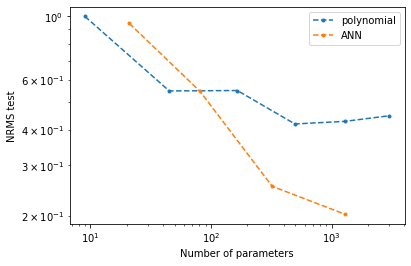

In [18]:
plt.loglog(Npar_pol,NRMS_pol,'--.')
plt.loglog(Npar_ANN,NRMS_ANN,'--.')
# plt.loglog([Nparameters],0.001,'o')
plt.xlabel('Number of parameters')
plt.ylabel('NRMS test')
plt.legend(['polynomial','ANN'])
plt.show()


**c)** Does this result differ from what we would expect from the theorem?

**Answer c):** We stopped the optimization early before fully converging (we also used a fixed learning rate), we make use of a finite number of training samples and we might suffer from local minima during the training. Furthermore, the theorem is only valid in the limit of $n \rightarrow \infty$. Lastly, we only tested it on one particular type of nonlinear function.

## Exercise 6: ANN for NARX

Let us apply ANN on the NARX example model we used during the last two exercise sets. 

#### Data Generation

**Run cell** below to generate the data, (no modification required)

The data is generated and split into NumPy arrays `Xtrain, Xval, Ytrain, Yval`.

where just as before each row of `Xtrain` is given by $[u_{k-nb}, u_{k-nb+1}, ..., u_{k-1}, y_{k-na}, y_{k-na+1}, ... y_{k-1}]$ and each corresponding element of `Ytrain` is $y_{k}$. 

We generate 5000 training samples which is condiderably more than in last exercise set.

In [19]:
import numpy as np
from matplotlib import pyplot as plt
def f(upast,ypast):
    ukm2, ukm1 = upast
    ykm2, ykm1 = ypast
    ystar = (0.8 - 0.5 * np.exp(-ykm1 ** 2)) * ykm1 - (0.3 + 0.9 * np.exp(-ykm1 ** 2)) * ykm2 \
           + ukm1 + 0.2 * ukm2 + 0.1 * ukm1 * ukm2 #the same weird function
    return ystar + np.random.normal(scale=0.01)

def get_NARX_data(ulist, f, na, nb):
    #init upast and ypast as lists.
    upast = [0.]*nb 
    ypast = [0.]*na 
    
    ylist = []
    for unow in ulist:
        #compute the current y given by f
        ynow = f(upast,ypast) 
        
        #update past arrays
        upast.append(unow)
        upast.pop(0)
        ypast.append(ynow)
        ypast.pop(0)
        
        #save result
        ylist.append(ynow)
    return np.array(ylist) #return result

##########
na, nb = 2, 2
##########

np.random.seed(42)
N = 5000 #more data than last time
ulist = np.random.normal(scale=1,size=N)
ylist = get_NARX_data(ulist,f,na,nb)

def make_training_data(ulist,ylist,na,nb):
    #Xdata = (Nsamples,Nfeatures)
    #Ydata = (Nsamples)
    Xdata = []
    Ydata = []
    #for loop over the data:
    for k in range(max(na,nb),len(ulist)): #skip the first few indexes
        Xdata.append(np.concatenate([ulist[k-nb:k],ylist[k-na:k]])) 
        Ydata.append(ylist[k]) 
    return np.array(Xdata), np.array(Ydata)

Xdata, Ydata = make_training_data(ulist, ylist, 2, 2)

from sklearn.model_selection import train_test_split 
Xtrain, Xval, Ytrain, Yval = train_test_split(Xdata, Ydata) 

#### Neural Network Construction and Training

**a)** Construct a 1 hidden layer neural network with 32 hidden nodes and sigmoid activation and train it using an optimizer (e.g. SGD, adam) on the training data for 50000 epochs. 

*tip: convert the NumPy arrays into torch arrays using `torch.as_tensor` or similar*

In [20]:
from torch import nn
import torch
class Network(nn.Module): #a)
    def __init__(self, n_in, n_hidden_nodes): #a)
        super(Network,self).__init__() #a)
        self.lay1 = nn.Linear(n_in,n_hidden_nodes).double() #a)
        self.lay2 = nn.Linear(n_hidden_nodes,1).double() #a)
    
    def forward(self,x): #a)
        #x = concatenated [upast and ypast] #a)
        x1 = torch.sigmoid(self.lay1(x)) #a)
        y = self.lay2(x1)[:,0] #a)
        return y #a)

n_hidden_nodes = 32 #a)
epochs = 50000 #a)

model = Network(Xtrain.shape[1], n_hidden_nodes) #a=)
optimizer = torch.optim.Adam(model.parameters()) #a)
Xtrain, Xval, Ytrain, Yval = [torch.as_tensor(x) for x in [Xtrain, Xval, Ytrain, Yval]] #convert it to torch arrays #a)
for epoch in range(epochs): #a)
    Loss = torch.mean((model(Xtrain)-Ytrain)**2) #a)
    optimizer.zero_grad() #a)
    Loss.backward() #a)
    optimizer.step() #a)
    if epoch%1000==0: #a) monitor
        print(epoch,Loss.item()) #a)

0 3.9269467999380177
1000 0.22772419201555125
2000 0.09139951127182655
3000 0.03587366516017438
4000 0.015544687522333912
5000 0.006234472437033867
6000 0.003494067256575495
7000 0.0024555211679152976
8000 0.0017749073747954335
9000 0.0013044154850081753
10000 0.0009813930455543534
11000 0.0007530440871592383
12000 0.0006063006822774712
13000 0.0005103437509323268
14000 0.00043425704537278107
15000 0.00036790467151848937
16000 0.0003214520052081094
17000 0.0002885680975870334
18000 0.0002568679426050339
19000 0.00022494297529810386
20000 0.00019626507014755966
21000 0.0001756205528992637
22000 0.000167893867134038
23000 0.00016291804218628652
24000 0.00015822988936934154
25000 0.00015713276102831484
26000 0.00015252114682738556
27000 0.00014772145688772523
28000 0.00014488433592127925
29000 0.0001422965061593528
30000 0.00014002773427285544
31000 0.00013822707184349395
32000 0.00013632071181023505
33000 0.00013438406514752524
34000 0.00013305848436324312
35000 0.00013172173926337028
36

#### Prediction Error

**b)** Visualize the prediction error on both the training set and the validation set by making residual plots. Also, calculate the NRMS prediction error on the validation set. 

*tip: use a_torch_array.numpy() to convert an torch array to a numpy array*

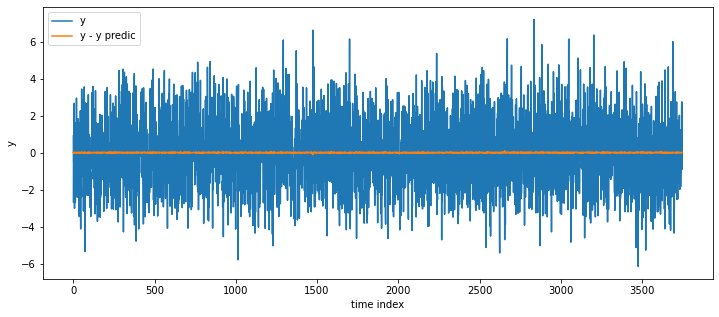

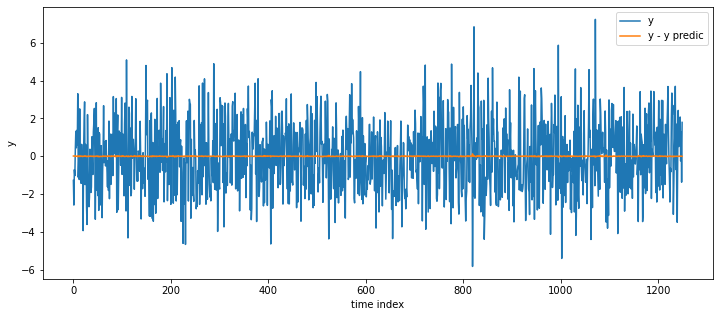

NRMS prediction 0.006458787179802138


In [21]:
#residual calculations and plotting
with torch.no_grad():
    Ytrain_pred = model(Xtrain) #b)
    res = Ytrain_pred - Ytrain #b)
    plt.figure(figsize=(12,5)) #b)
    plt.plot(Ytrain) #b)
    plt.plot(res) #b)
    plt.xlabel('time index'); plt.ylabel('y'); plt.legend(['y','y - y predic'])#b)
    plt.show() #b)

    Yval_pred = model(Xval) #b)
    res = Yval_pred - Yval #b)
    plt.figure(figsize=(12,5)) #b)
    plt.plot(Yval) #b)
    plt.plot(res) #b)
    plt.xlabel('time index'); plt.ylabel('y'); plt.legend(['y','y - y predic'])#b)
    plt.show() #b)
    print('NRMS prediction',np.mean((res**2).numpy())**0.5/np.std(Yval.numpy())) #b)

#### Simulation Error

**c)** Observe how the `model` is used in simulation in the cell below and plot the results of this simulation in a residual plot and print the NRMS simulation. 

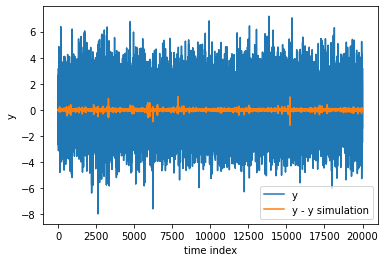

NRMS= 0.03169264686095105


In [22]:

np.random.seed(43)
utest = np.random.normal(scale=1.0,size=20000) #create test data
ytest = get_NARX_data(utest,f,na,nb)


def fmodel(upast,ypast):
    x = np.concatenate([upast,ypast]) #concat to Xtrain format
    xten = torch.as_tensor(x)[None,:] #convert to tensor to one with shape (1,na+nb)
    with torch.no_grad():
        ypred = model(xten)[0] #pass through network and take the first sample
    return ypred.numpy() #convert it back into a number
ytest_sim = get_NARX_data(utest, fmodel, na, nb) #apply utest to fmodel

plt.plot(ytest) #c)
plt.plot(ytest-ytest_sim) #c)
plt.xlabel('time index'); plt.ylabel('y'); plt.legend(['y','y - y simulation']) #c)
plt.show() #c)
print('NRMS=',np.mean((ytest-ytest_sim)**2)**0.5/np.std(ytest)) #c)
